In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from arch import arch_model
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from data.stock_data import StockData

In [2]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()

# Drop all the rows where Log Return is exactly 0
sp500 = sp500[sp500['Log Return'] != 0]
sp500 = sp500.dropna()
sp500

# Make the sp500 be on a weekly frequency instead of daily
sp500 = sp500.resample('W').sum()
sp500.to_csv('data/sp500_weekly.csv')


[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

,Log Return,Squared Return
Date,,
2006-01-08,1.303720,1.009653
2006-01-15,0.167896,0.665918
2006-01-22,-2.049422,4.014040
2006-01-29,1.746854,1.239267
2006-02-05,-1.545704,1.323481
...,...,...
2022-12-04,1.125743,11.759279
2022-12-11,-3.430731,6.504358
2022-12-18,-2.106730,10.530129


In [4]:
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
0,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
1,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
2,2006-03,4.515,0.338,0.006086,0.085002,3.362649,-0.020833
3,2006-04,4.650,0.419,-0.002866,0.078793,3.545735,0.000000
4,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667,-0.021277
...,...,...,...,...,...,...,...
206,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974,-0.027778
207,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320,-0.028571
208,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609,0.088235
209,2023-06,5.153,-1.334,0.004591,0.037450,2.969178,-0.027027


In [5]:
# Calculate the monthly RV
sp500['YearMonth'] = sp500.index.to_period('M')
monthly_sum = sp500.groupby('YearMonth')['Squared Return'].transform('sum')
sp500['RV'] = monthly_sum

In [6]:
# Merge the hf stock data with lf macro data based on the month
sp500.index = pd.to_datetime(sp500.index)
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])
sp500['YearMonth'] = sp500.index.to_period('M')
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')
macro_df.drop('Year-Month', axis=1, inplace=True)
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')
merged_df.set_index('Date', inplace=True)

In [7]:
merged_df['Squared Return'] = np.sqrt(merged_df['Squared Return'])
merged_df = merged_df.rename(columns={'Squared Return': 'RV', 'RV': 'Monthly RV'})
merged_df

,Log Return,RV,YearMonth,Monthly RV,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
Date,,,,,,,,,,
2006-01-08,1.303720,1.004815,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-15,0.167896,0.816038,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-22,-2.049422,2.003507,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-29,1.746854,1.113224,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-02-05,-1.545704,1.150426,2006-02,5.433545,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
...,...,...,...,...,...,...,...,...,...,...
2022-12-04,1.125743,3.429181,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778
2022-12-11,-3.430731,2.550364,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778
2022-12-18,-2.106730,3.245016,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778


### Create pricipal components from macro data

In [8]:
# Features list should include everything else than Log Return	Squared Return	RV	YearMonth
# Get all column names from merged_df
all_cols = merged_df.columns.tolist()

# Define the columns to exclude from features list
exclude_cols = ['Log Return', 'Squared Return', 'RV', 'YearMonth']

# Create the features list
features = [col for col in all_cols if col not in exclude_cols]

# Print the features list
display(features)

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x

['Monthly RV',
 '3 Month T-Bill Rate',
 'Yield Curve Slope',
 'Reer Change',
 'Change Oil Price',
 'CPI',
 'Unemployment Rate Change']

array([[-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       [-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       [-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       ...,
       [-0.00624395,  2.08457062, -1.85996275, ..., -0.10497698,
         1.9858082 , -0.19512588],
       [-0.00624395,  2.08457062, -1.85996275, ..., -0.10497698,
         1.9858082 , -0.19512588],
       [-0.36963666,  2.28782479, -2.4879254 , ..., -0.21831342,
         1.96398   , -0.20000439]])

In [9]:
# Create principal components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [10]:
merged_df = (merged_df.reset_index()
                      .join(principalDf, how='right')
                      .set_index('Date'))

merged_df.to_csv('data/merged_df.csv')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 887 entries, 2006-01-08 to 2023-01-01
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Log Return                887 non-null    float64  
 1   RV                        887 non-null    float64  
 2   YearMonth                 887 non-null    period[M]
 3   Monthly RV                887 non-null    float64  
 4   3 Month T-Bill Rate       887 non-null    float64  
 5   Yield Curve Slope         887 non-null    float64  
 6   Reer Change               887 non-null    float64  
 7   Change Oil Price          887 non-null    float64  
 8   CPI                       887 non-null    float64  
 9   Unemployment Rate Change  887 non-null    float64  
 10  principal component 1     887 non-null    float64  
 11  principal component 2     887 non-null    float64  
dtypes: float64(11), period[M](1)
memory usage: 90.1 KB


In [11]:
merged_df['Monthly RV'].head(60)

Date
2006-01-08     6.928878
2006-01-15     6.928878
2006-01-22     6.928878
2006-01-29     6.928878
2006-02-05     5.433545
2006-02-12     5.433545
2006-02-19     5.433545
2006-02-26     5.433545
2006-03-05     5.449841
2006-03-12     5.449841
2006-03-19     5.449841
2006-03-26     5.449841
2006-04-02     7.069914
2006-04-09     7.069914
2006-04-16     7.069914
2006-04-23     7.069914
2006-04-30     7.069914
2006-05-07    10.399518
2006-05-14    10.399518
2006-05-21    10.399518
2006-05-28    10.399518
2006-06-04    18.128810
2006-06-11    18.128810
2006-06-18    18.128810
2006-06-25    18.128810
2006-07-02    20.359030
2006-07-09    20.359030
2006-07-16    20.359030
2006-07-23    20.359030
2006-07-30    20.359030
2006-08-06     4.313300
2006-08-13     4.313300
2006-08-20     4.313300
2006-08-27     4.313300
2006-09-03     4.078693
2006-09-10     4.078693
2006-09-17     4.078693
2006-09-24     4.078693
2006-10-01     5.890157
2006-10-08     5.890157
2006-10-15     5.890157
2006-10-22 

# MIDAS DATAFRAME

In [12]:
midas_df = (merged_df[['Log Return', 'RV', 'Monthly RV', 'principal component 1', 'principal component 2', 'YearMonth']]
                    .rename(columns={'YearMonth': 'year_month', 'Log Return': 'r', 'RV': 'RV W', 'Monthly RV': 'RV M', 'principal component 1': 'PC1', 'principal component 2': 'PC2'}))

midas_df.to_csv('data/r_midas_df.csv')

In [13]:
# Sort values from least frequent to most frequent in PC1 column
midas_df['PC2'].value_counts()

 2.590898    5
-2.041001    5
-0.755749    5
-0.344723    5
 0.192226    5
            ..
 0.610603    1
 1.847032    1
 0.610603    1
 0.610603    1
 1.763033    1
Name: PC2, Length: 209, dtype: int64

In [14]:
sp500_returns = sp500[['Log Return', 'Squared Return']]
sp500_returns

,Log Return,Squared Return
0,1.303720,1.009653
1,0.167896,0.665918
2,-2.049422,4.014040
3,1.746854,1.239267
4,-1.545704,1.323481
...,...,...
882,1.125743,11.759279
883,-3.430731,6.504358
884,-2.106730,10.530129
885,-0.195917,5.469060


# Descriptive Statistics

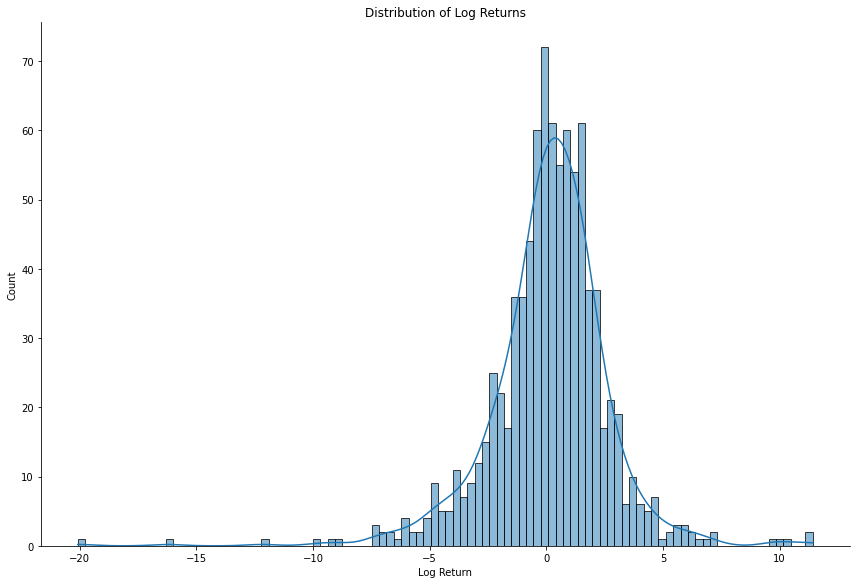


Descriptive statistics for Log Returns:
count    887.000000
mean       0.124833
std        2.563441
min      -20.083751
25%       -0.985532
50%        0.269669
75%        1.481964
max       11.423675
Name: Log Return, dtype: float64

Skewness (Log Returns):  -0.9555603534895724
Kurtosis (Log Returns):  8.240317958221539


In [15]:
# Function to plot distribution, describe statistics, and calculate skewness and kurtosis
def analyze_return_distribution(series, title):
    sns.displot(series.dropna(), bins=100, kde=True, height=8, aspect=1.5)
    plt.title(f'Distribution of {title}')
    plt.show()

    # Descriptive statistics for the returns
    print(f'\nDescriptive statistics for {title}:')
    print(series.describe())

    # Skewness and kurtosis for returns
    print(f'\nSkewness ({title}): ', skew(series.dropna()))
    print(f'Kurtosis ({title}): ', kurtosis(series.dropna()))

# Assuming you have a dataframe named sp500 with columns 'Log Return' and 'Squared Return'
analyze_return_distribution(sp500['Log Return'], 'Log Returns')

In [16]:
# Find the date of highest squared return in sp500
sp500.sort_values(ascending=False, by='Squared Return')


,Date,Log Return,Squared Return,YearMonth,RV
740,2020-03-15,-9.203470,289.535432,2020-03,776.217039
741,2020-03-22,-16.227902,245.049951,2020-03,776.217039
145,2008-10-19,4.493711,227.734586,2008-10,560.384344
742,2020-03-29,9.769671,138.984228,2020-03,776.217039
150,2008-11-23,-8.761840,133.507925,2008-11,489.653814
...,...,...,...,...,...
412,2013-12-01,0.058165,0.083986,2013-12,7.333245
693,2019-04-21,-0.081889,0.083273,2019-04,3.698587
371,2013-02-17,0.122459,0.048290,2013-02,7.590694
260,2011-01-02,0.069201,0.043016,2011-01,8.126404


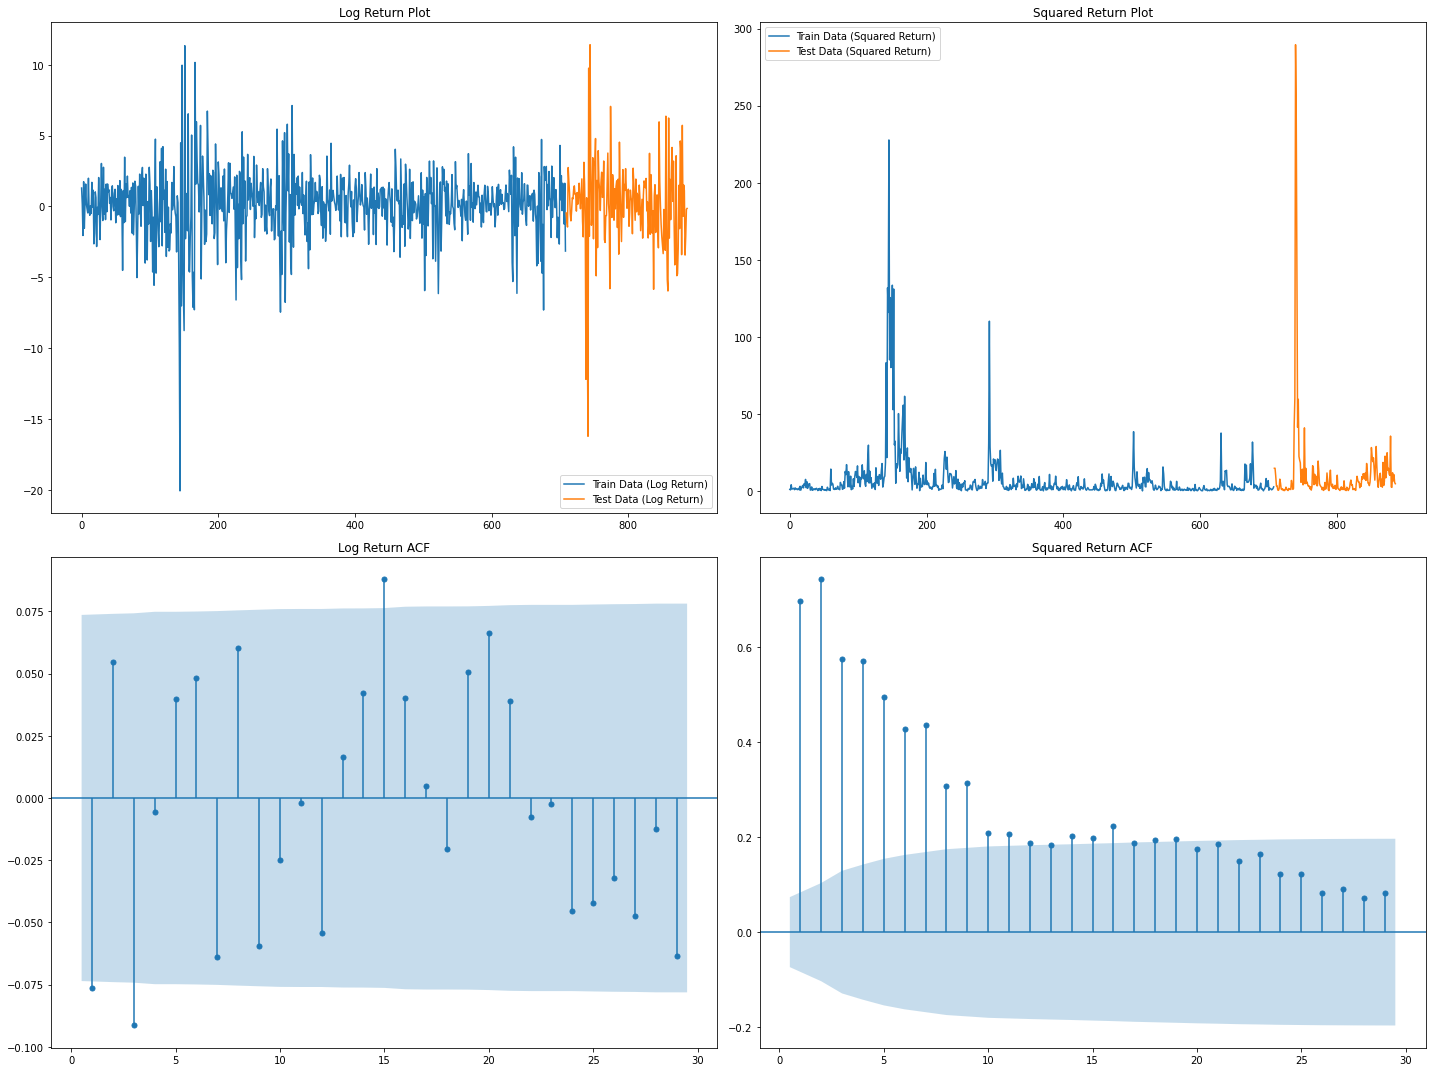

In [17]:
split = int(len(sp500) * 0.8)
train, test = sp500[:split], sp500[split:]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# First row: Plot the train and test sets for Log Return and Squared Return
axes[0, 0].plot(train['Log Return'], label='Train Data (Log Return)')
axes[0, 0].plot(test['Log Return'], label='Test Data (Log Return)')
axes[0, 0].legend()
axes[0, 0].set_title('Log Return Plot')

axes[0, 1].plot(train['Squared Return'], label='Train Data (Squared Return)')
axes[0, 1].plot(test['Squared Return'], label='Test Data (Squared Return)')
axes[0, 1].legend()
axes[0, 1].set_title('Squared Return Plot')

# Second row: Plot the autocorrelation of the returns and squared returns
plot_acf(train['Log Return'].dropna(), ax=axes[1, 0], zero=False)
axes[1, 0].set_title('Log Return ACF')

plot_acf(train['Squared Return'].dropna(), ax=axes[1, 1], zero=False)
axes[1, 1].set_title('Squared Return ACF')

# Adjust layout for clarity
plt.tight_layout()

plt.show()


In [18]:
# Perform an ADF test on the data
adf_result = adfuller(sp500['Log Return'].dropna())

# adf test value and p-value
adf, p_value, *_ = adf_result

# Print out adf and its p-value
print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')

ADF Statistic: -17.833380608448792
p-value: 3.1268528824458308e-30


In [19]:
display(merged_df.head(2), features)

,Log Return,RV,YearMonth,Monthly RV,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change,principal component 1,principal component 2
Date,,,,,,,,,,,,
2006-01-08,1.303720,1.004815,2006-01,6.928878,4.37,0.157,-0.009324,0.112713,3.985317,-0.040816,-2.753169,0.610603
2006-01-15,0.167896,0.816038,2006-01,6.928878,4.37,0.157,-0.009324,0.112713,3.985317,-0.040816,-2.753169,0.610603


['Monthly RV',
 '3 Month T-Bill Rate',
 'Yield Curve Slope',
 'Reer Change',
 'Change Oil Price',
 'CPI',
 'Unemployment Rate Change']

# VIsualizing low frequency data

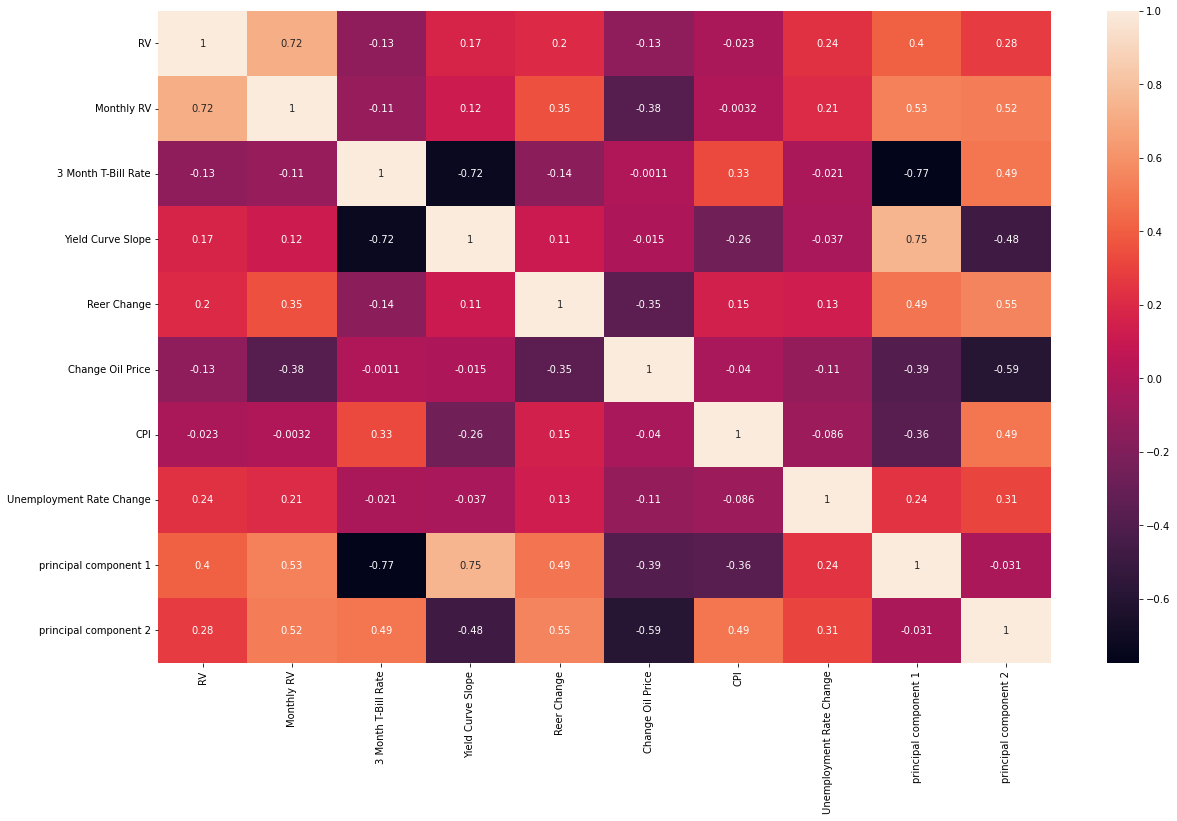

In [20]:
visualization_df = merged_df[features + ['principal component 1', 'principal component 2', 'YearMonth', 'RV']]

# Take only one row of each YearMonth
visualization_df = visualization_df.groupby('YearMonth').first()

# Visualize the correlation, make RV the first column row
visualization_df = visualization_df[['RV'] + features + ['principal component 1', 'principal component 2']]
visualization_df

# Plot the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(visualization_df.corr(), annot=True)
plt.show()

# Define the data to be used in the models

In [21]:
return_data = merged_df['Log Return']
volatility_data = merged_df['RV']

test_size =  173

In [22]:
# Create a GARCH(1, 1) model, first train it on train data, then test on test data

garch11_model = arch_model(return_data[:-test_size], p=1, q=1)
fixed_garch11_model = garch11_model.fit()
# garch11_model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 134699822519.00531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 410799861.4525362
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1664.1118653904477
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1537.8798228927403
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1500.844614381463
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1499.586613491571
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1499.301028809003
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1499.3002448708403
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1499.3002357163068
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1499.300235192603
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1499.300235192603
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


In [23]:
fixed_garch11_model.params

mu          0.279289
omega       0.376470
alpha[1]    0.281077
beta[1]     0.665331
Name: params, dtype: float64

In [24]:
fixed_gjr_garch_model = arch_model(return_data[:-test_size], p=1, o=1, q=1).fit(disp='off')
fixed_egarch_model = arch_model(return_data[:-test_size], p=1, o=1, q=1, vol='EGARCH').fit(disp='off')
model_list = [fixed_garch11_model, fixed_egarch_model, fixed_gjr_garch_model]


# alpha	beta	gamma	omega	se_alpha	se_beta	se_gamma	se_omega	t_alpha	t_beta	t_gamma	t_omega	AIC	BIC
# Get same values as above in a dataframe for the fixed_gjr_garch_model and fixed_egarch_model

import pandas as pd

# Assuming arch_model and return_data are already defined
# and the models in model_list have been fitted

# Create a function to retrieve model parameters and statistics
def get_model_params(model):
    return {
        'alpha': model.params['alpha[1]'],
        'beta': model.params['beta[1]'],
        'gamma': model.params.get('gamma[1]', 0), # If gamma doesn't exist, use 0
        'omega': model.params['omega'],
        'se_alpha': model.std_err['alpha[1]'],
        'se_beta': model.std_err['beta[1]'],
        'se_gamma': model.std_err.get('gamma[1]', 0), 
        'se_omega': model.std_err['omega'],
        't_alpha': model.tvalues['alpha[1]'],
        't_beta': model.tvalues['beta[1]'],
        't_gamma': model.tvalues.get('gamma[1]', 0), 
        't_omega': model.tvalues['omega'],
        'AIC': model.aic,
        'BIC': model.bic
    }

# Generate a DataFrame for each model and concatenate them
model_dfs = pd.concat([pd.DataFrame([get_model_params(model)]) for model in model_list], ignore_index=True)



# Extract information from fixed models

In [25]:
model_names = ["GARCH(1, 1)", "EGARCH", "GJR-GARCH"]
model_dfs.index = model_names

# Create a simple fixed parameter GARCH(1, 1) model for comparison purposes

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4055.291946249725
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30013681712.012627
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1827.9856485286357
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1641.7966039892433
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1466.9050886955588
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1455.975923885077
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1455.9006461065667
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1455.8832712709232
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1455.8807279145217
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1455.8806675831456
Iteration:     11,   Func. Count:     68,   Neg. LLF: 1455.880658371327
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1455.8806570406314
Iteration:     13,   Func. Count:     77,   Neg. LLF: 1455.8806570404643
Optimization terminated successfully    (Exit mode 0)


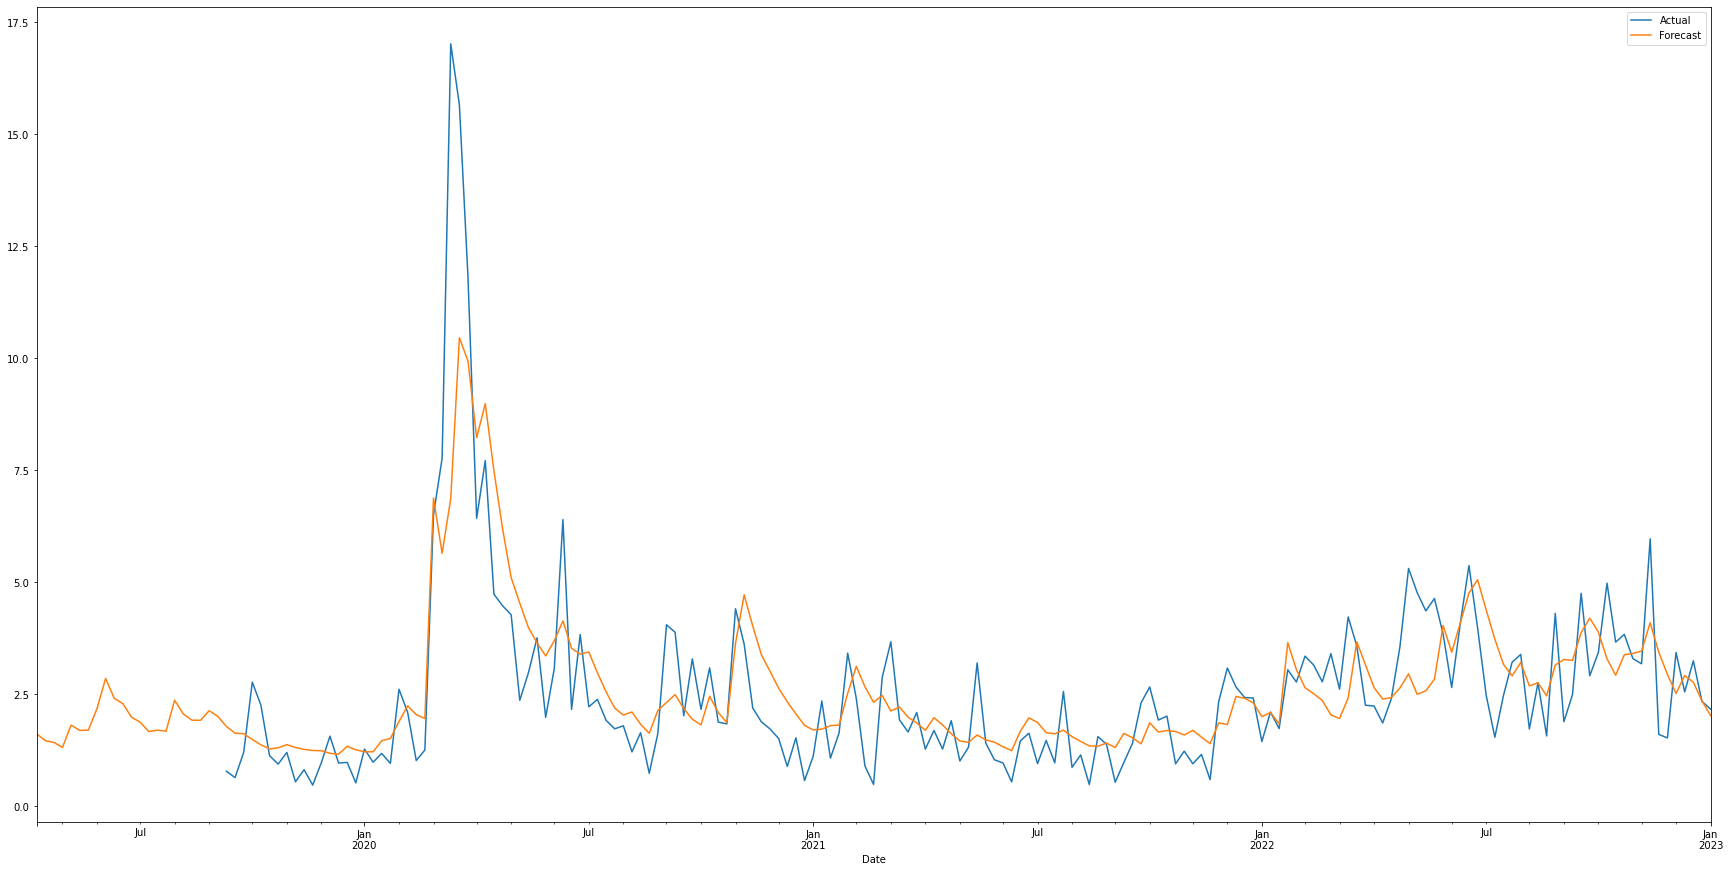

In [26]:
fixed_garch11 = arch_model(return_data, p=1, q=1)

res = fixed_garch11.fit(last_obs=693, update_freq=1)
forecasts_fixed_garch11 = res.forecast(horizon=1)
forecast_df = forecasts_fixed_garch11.variance
vol_df = pd.DataFrame(volatility_data[-test_size:])
combined_data = pd.concat([vol_df, np.sqrt(forecast_df)], axis=1)

combined_data.columns = ['Actual', 'Forecast']

# Plot the data
combined_data.plot(figsize=(30, 15))
plt.show()

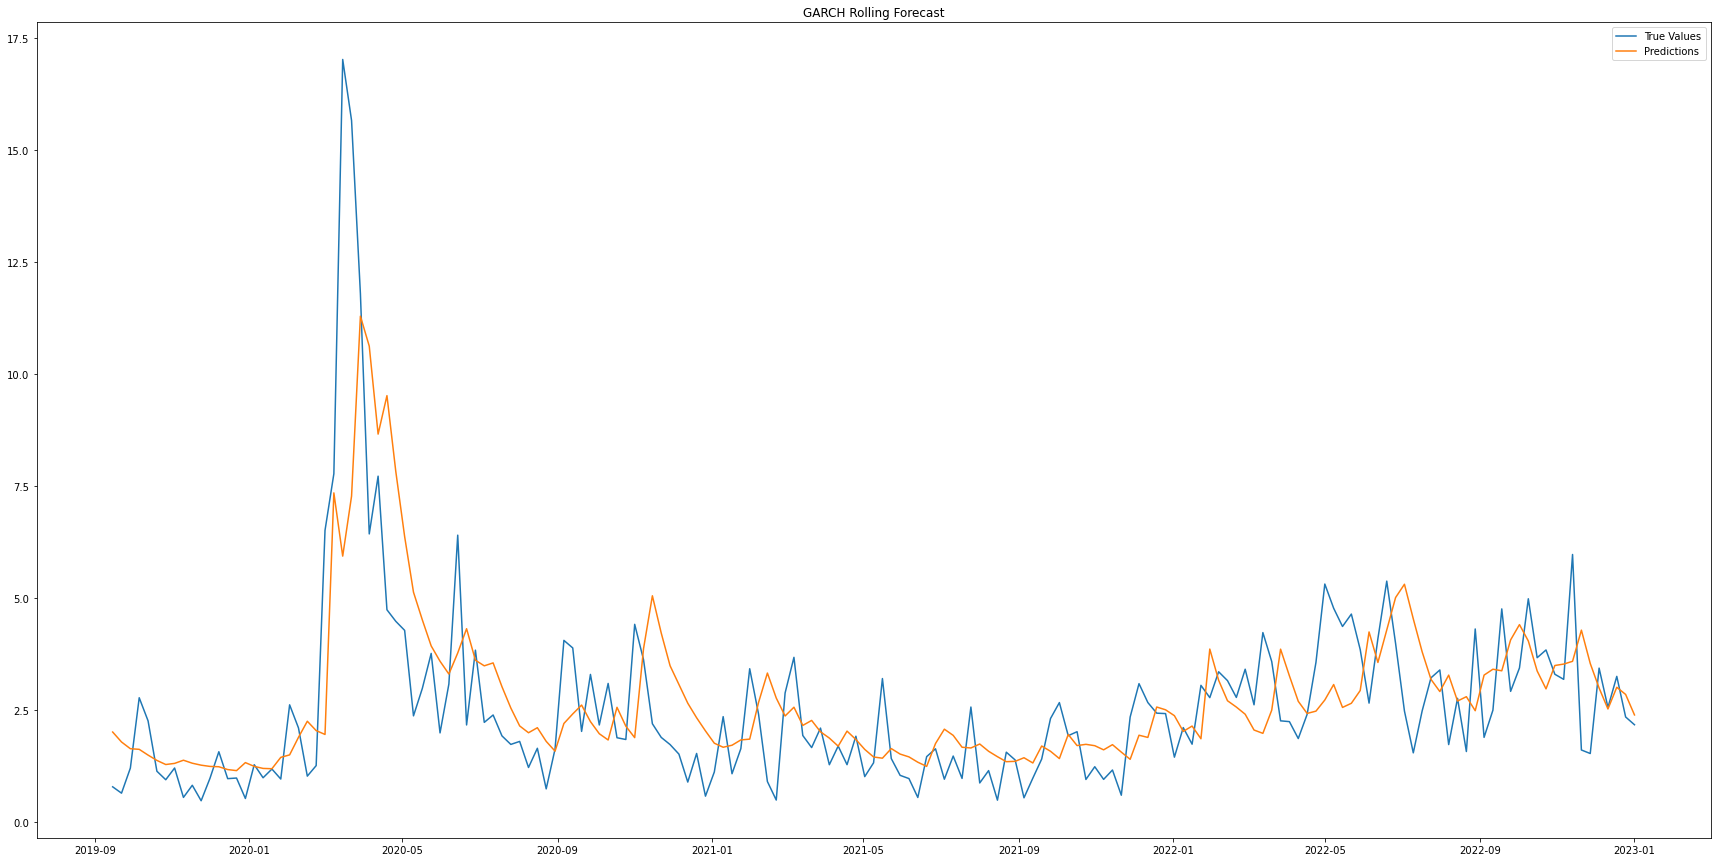

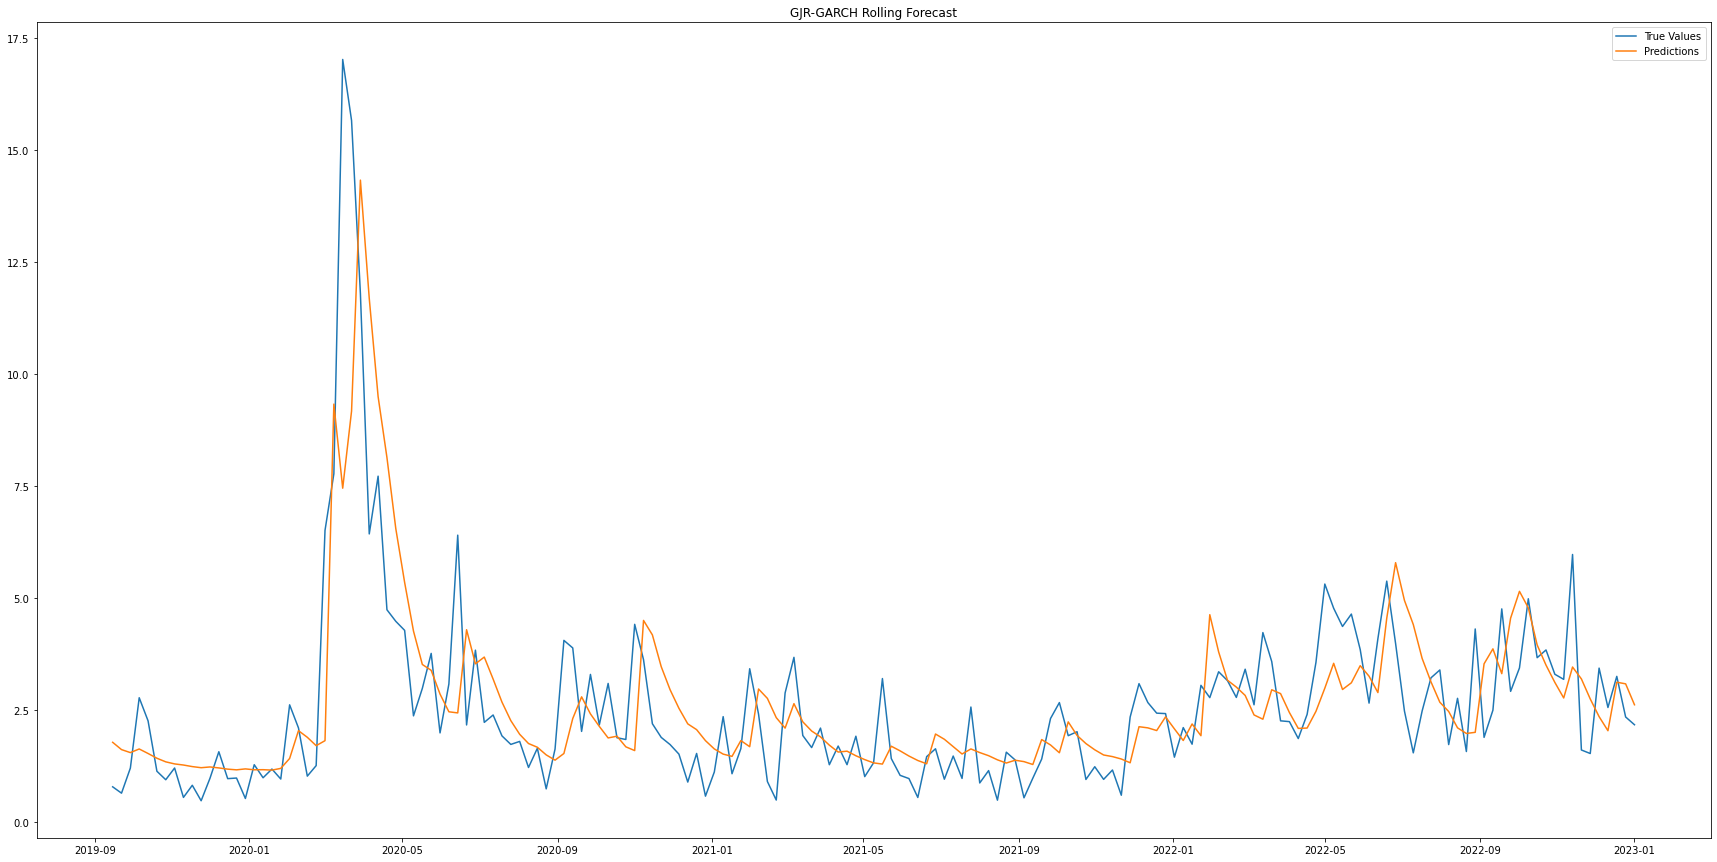

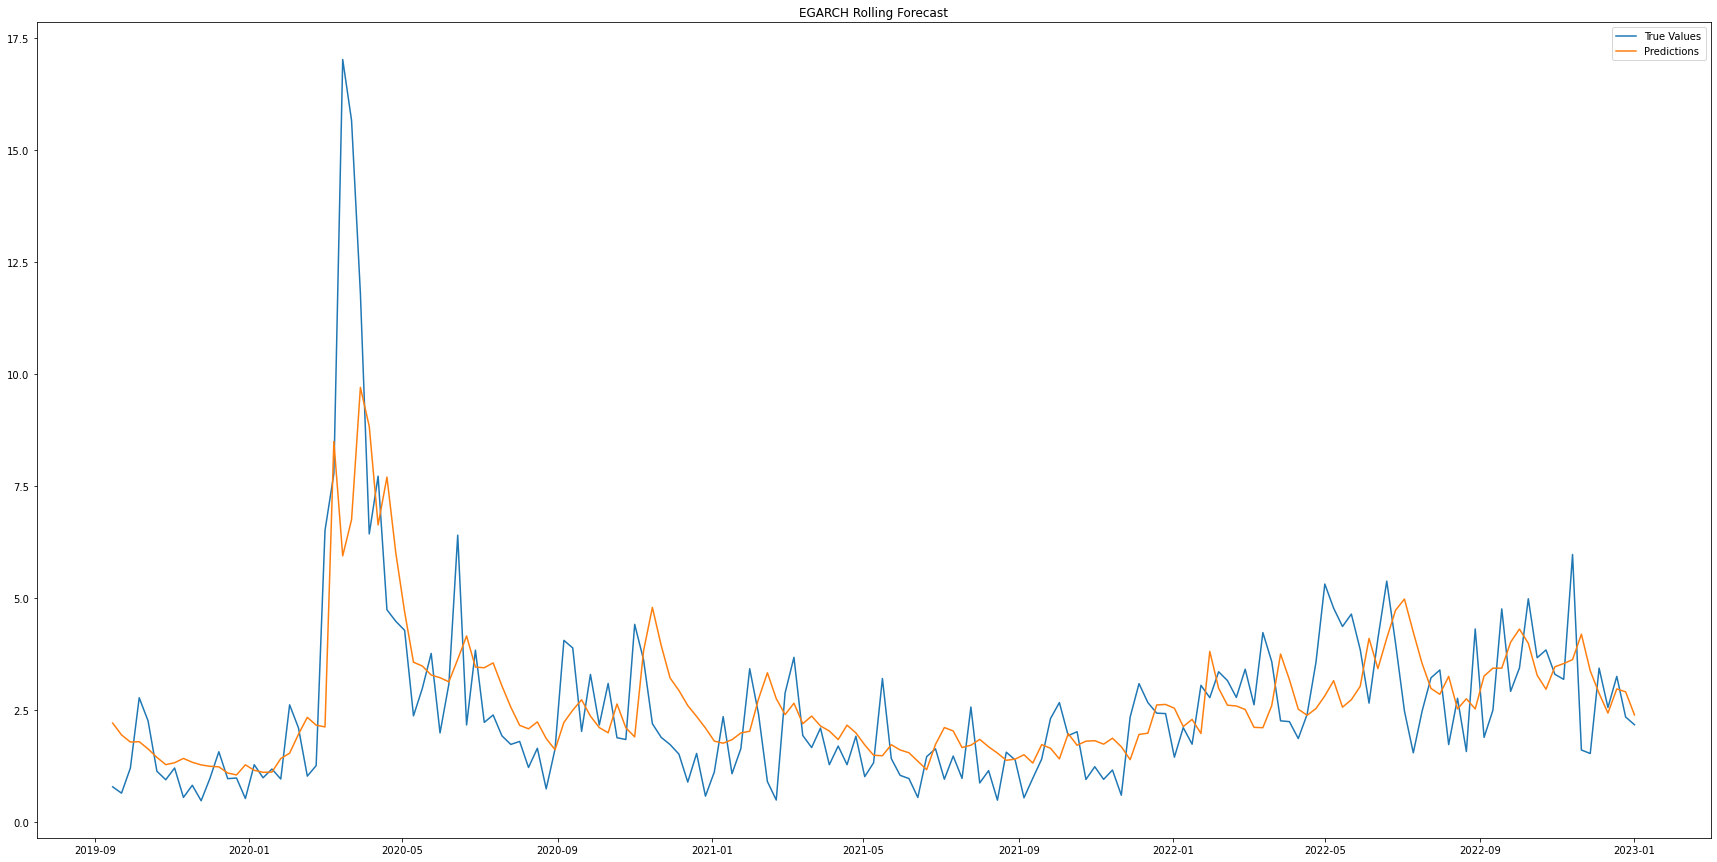

In [27]:
# Define a function to perform rolling forecast with different GARCH models
def rolling_garch_forecast(data, test_size, garch_type='GARCH', p=1, o=0, q=1):
    rolling_predictions = []
    
    for i in range(test_size):
        train = data[:-(test_size-i)]
        if garch_type == 'GARCH':
            model = arch_model(train, p=p, q=q)
        elif garch_type == 'GJR-GARCH':
            model = arch_model(train, p=p, o=1, q=q)
        elif garch_type == 'EGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='EGARCH')
        elif garch_type == 'FIGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='FIGARCH')
        else:
            raise ValueError("Unsupported GARCH model type")
        
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(pred.variance.values[-1,:][0])
    
    rolling_predictions = pd.Series(rolling_predictions, index=data.index[-test_size:])
    return np.sqrt(rolling_predictions)

# Function to plot the results
def plot_rolling_forecast(true_data, predicted_data, title):
    plt.figure(figsize=(12, 8))
    true, = plt.plot(true_data, label='True Values')
    preds, = plt.plot(predicted_data, label='Predictions')
    plt.title(title)
    plt.legend(handles=[true, preds])
    plt.show()

def plot_volatility(true_data, predicted_data, title):
    plt.figure(figsize=(30, 15))
    true, = plt.plot(true_data)
    preds, = plt.plot(predicted_data)
    plt.title(title)
    plt.legend(['True Values', 'Predictions'])
    plt.show()

garch11_predictions = rolling_garch_forecast(return_data, test_size, 'GARCH')
gjr_garch_predictions = rolling_garch_forecast(return_data, test_size, 'GJR-GARCH')
egarch_predictions = rolling_garch_forecast(return_data, test_size, 'EGARCH')
figarch_predictions = rolling_garch_forecast(return_data, test_size, 'FIGARCH')

# Plotting the results
plot_volatility(volatility_data[-test_size:], garch11_predictions, 'GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], gjr_garch_predictions, 'GJR-GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], egarch_predictions, 'EGARCH Rolling Forecast')

# RNGARCH

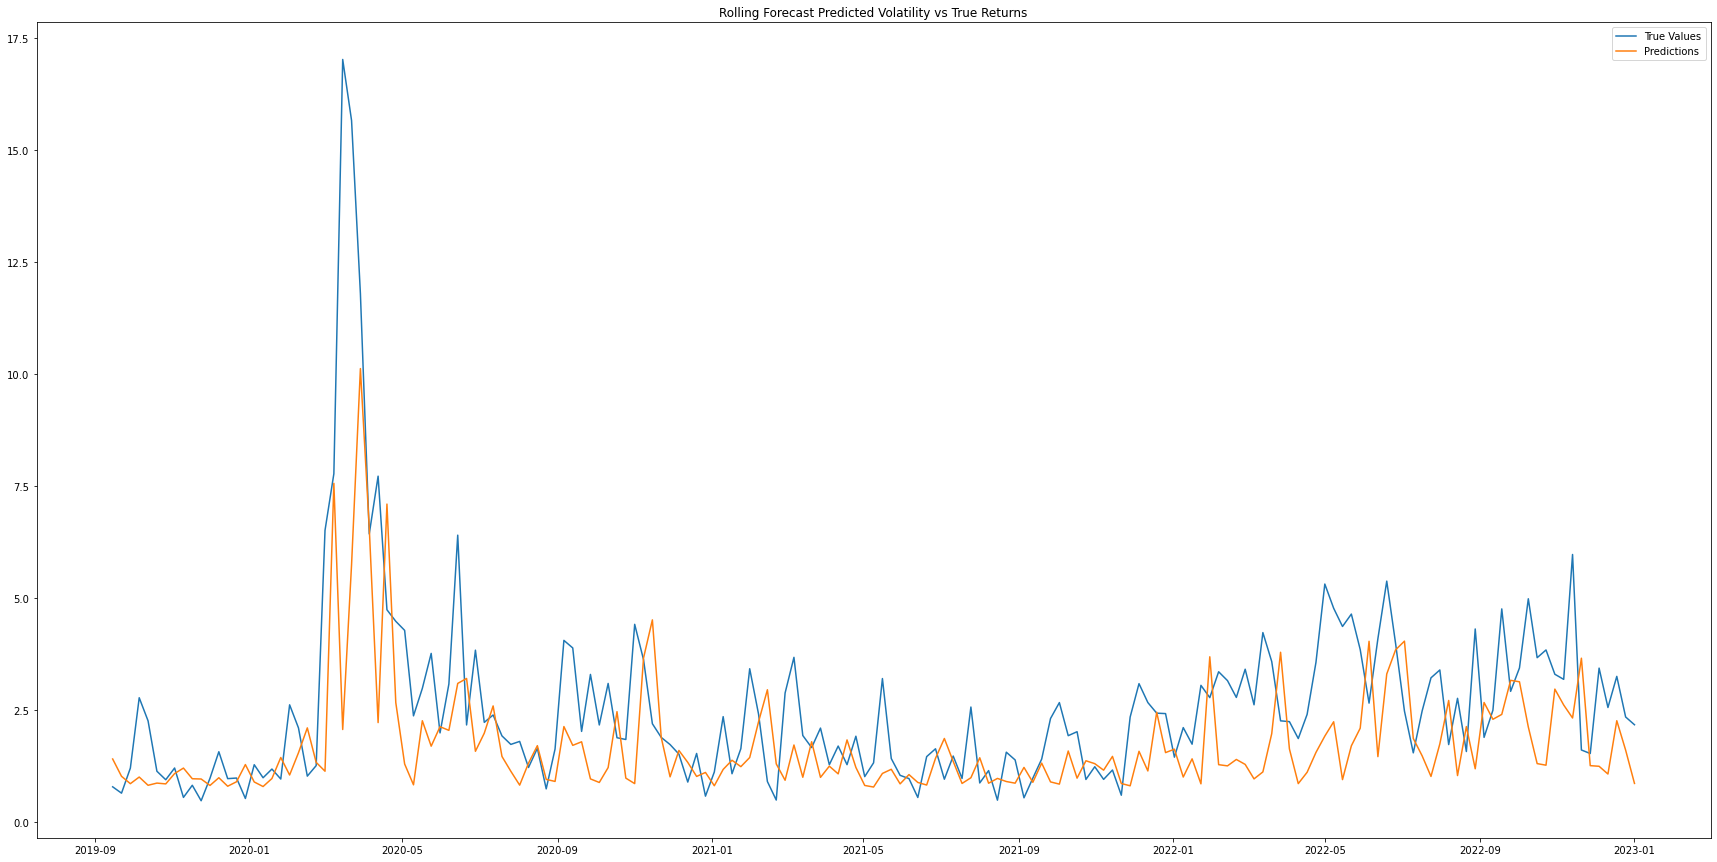

In [28]:
def garch_forecast(omega, alpha, beta, r):
    iT = len(r)
    variance = np.zeros(iT)

    for i in range(iT):
        if i == 0:
            # set initial value to long run variance
            variance[i] = omega / (1 - alpha - beta)
        else:
            # standard GARCH(1,1) recursion
            variance[i] = omega + alpha * r[i - 1] ** 2 + beta * variance[i - 1]

    return np.sqrt(variance)

# Random number generate omega, alpha, beta so that they sum up to one
omega, alpha, beta = [np.random.rand() for _i in range(3)]
standardizer_value = sum([omega, alpha, beta])

# Make sure they sum up to one
omega = omega / (standardizer_value)
alpha = alpha / (standardizer_value)
beta = beta / (standardizer_value)

forecasts = garch_forecast(omega, alpha, beta, r=return_data)

# Turn the numpy array to series
rngarch_predictions = pd.Series(forecasts, index=return_data.index)

plt.figure(figsize=(30,15))
true, = plt.plot(volatility_data[-test_size:])
preds, = plt.plot(rngarch_predictions[-test_size:])
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])

## Performance Metrics

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Define your efficiency metrics functions here
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def rmspe(actual, predicted):
    return np.sqrt(np.mean(np.square((actual - predicted) / actual)))

def mda(actual, predicted):
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])
        ).astype(int)
    )

def r_squared(actual, predicted):
    # Need to add a constant to use OLS
    predicted = sm.add_constant(predicted)
    model = sm.OLS(actual, predicted)
    results = model.fit()
    return results.rsquared

# Define the model efficiency function
def model_efficiency(actual, predicted, title):
    return pd.DataFrame(
        {
            "MAPE": mape(actual, predicted),
            "RMSPE": rmspe(actual, predicted),
            "MDA": mda(actual, predicted),
            "R^2": r_squared(actual, predicted),
        },
        index=[title],
    )

actual_volatility = volatility_data[-test_size:].values

# Create a dictionary mapping model names to their predictions
model_predictions = {
    'GARCH(1,1)-FIXED': forecasts_fixed_garch11.variance,
    'GARCH(1,1)': garch11_predictions,
    'GJR-GARCH': gjr_garch_predictions,
    'EGARCH': egarch_predictions,
    'RNGARCH': rngarch_predictions
}

# Initialize an empty DataFrame to store efficiency metrics for all models
all_model_efficiency = pd.DataFrame()

# Loop over the dictionary and compute efficiency metrics
for model_name, predictions in model_predictions.items():
    # Compute the efficiency metrics for the current model
    efficiency = model_efficiency(actual_volatility, predictions[-test_size:].values, model_name)
    
    # Append the efficiency DataFrame to the all_model_efficiency DataFrame
    all_model_efficiency = pd.concat([all_model_efficiency, efficiency])

# Display the efficiency metrics for all models
print(all_model_efficiency)


                      MAPE      RMSPE       MDA       R^2
GARCH(1,1)-FIXED  4.889120  12.655928  0.538534  0.643797
GARCH(1,1)        0.532645   0.800698  0.651163  0.428299
GJR-GARCH         0.453856   0.664854  0.703488  0.540142
EGARCH            0.528268   0.801334  0.662791  0.471812
RNGARCH           0.457680   0.562090  0.633721  0.297717


In [30]:
# midas_forecasts

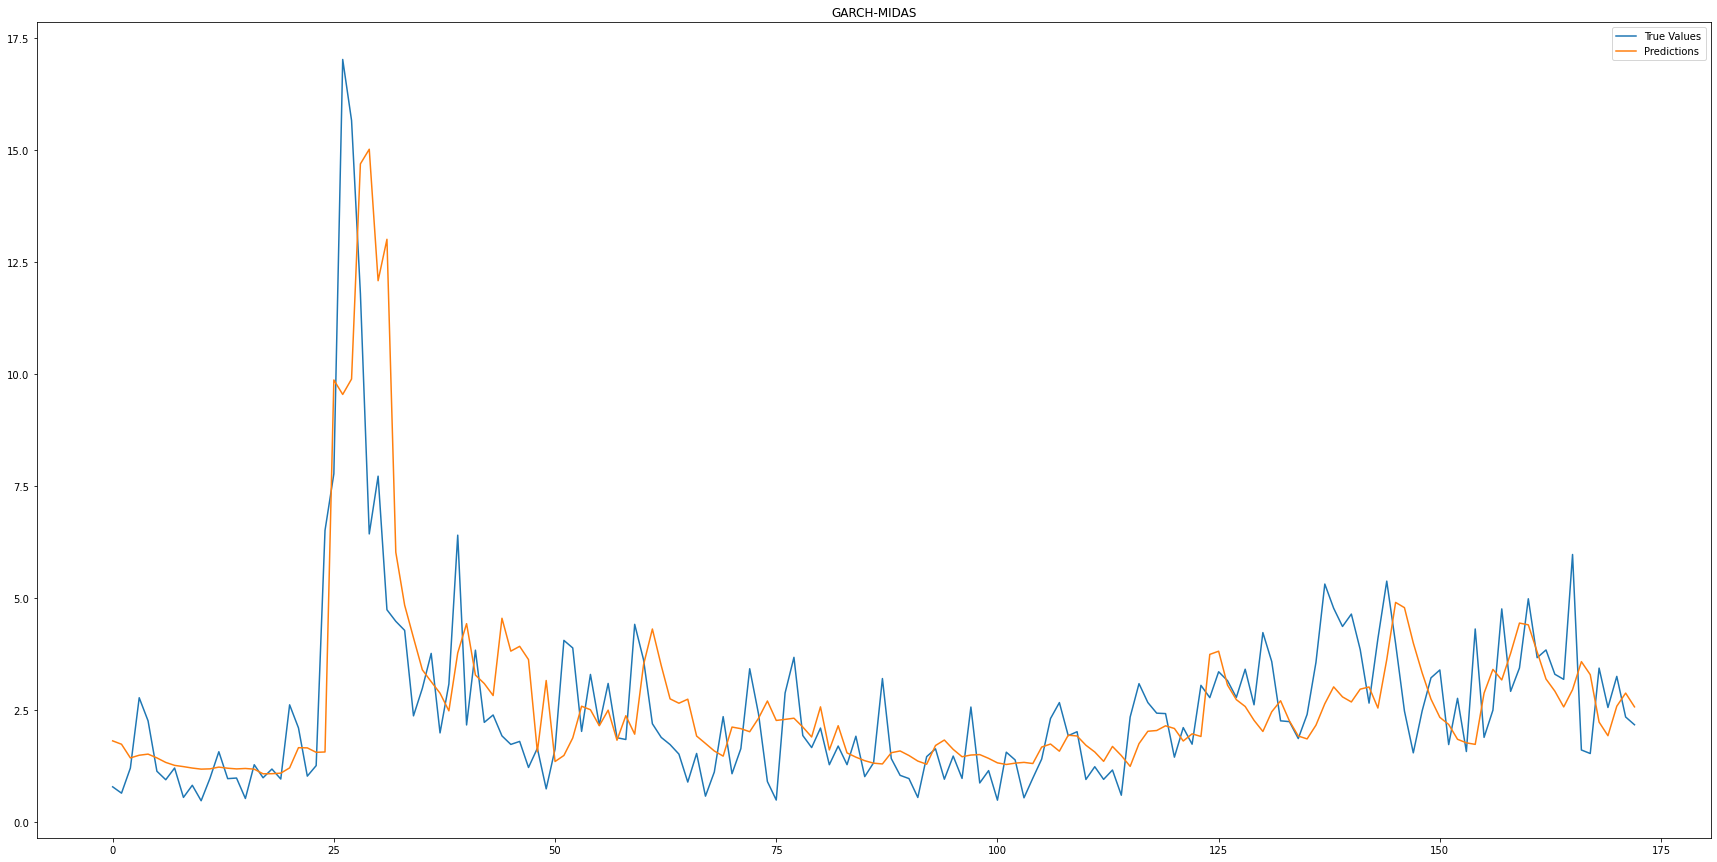

In [31]:
midas_forecasts = pd.read_csv('data/out_of_sample_midas.csv')

model_efficiency(midas_forecasts['RV'].values, midas_forecasts['GARCH_MIDAS'].values, 'GARCH-MIDAS')
plot_volatility(midas_forecasts['RV'].values, midas_forecasts['GARCH_MIDAS'].values, 'GARCH-MIDAS')

In [32]:
midas_forecasts['GARCH_MIDAS']

0      1.805438
1      1.730095
2      1.424707
3      1.484678
4      1.509746
         ...   
168    2.224612
169    1.920564
170    2.578786
171    2.871989
172    2.564487
Name: GARCH_MIDAS, Length: 173, dtype: float64

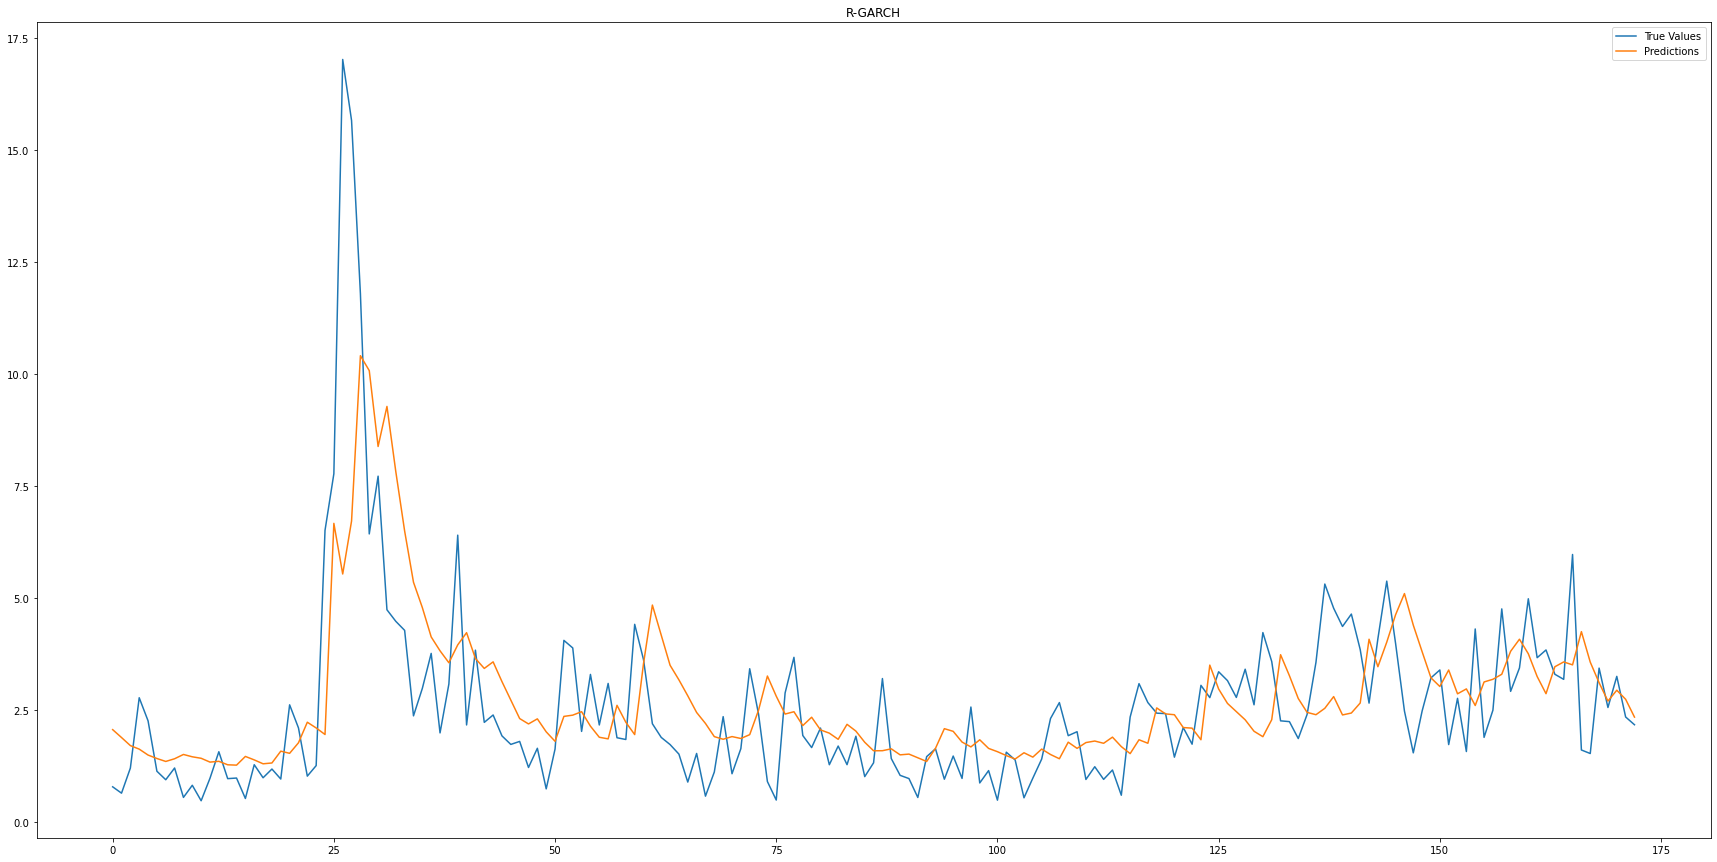

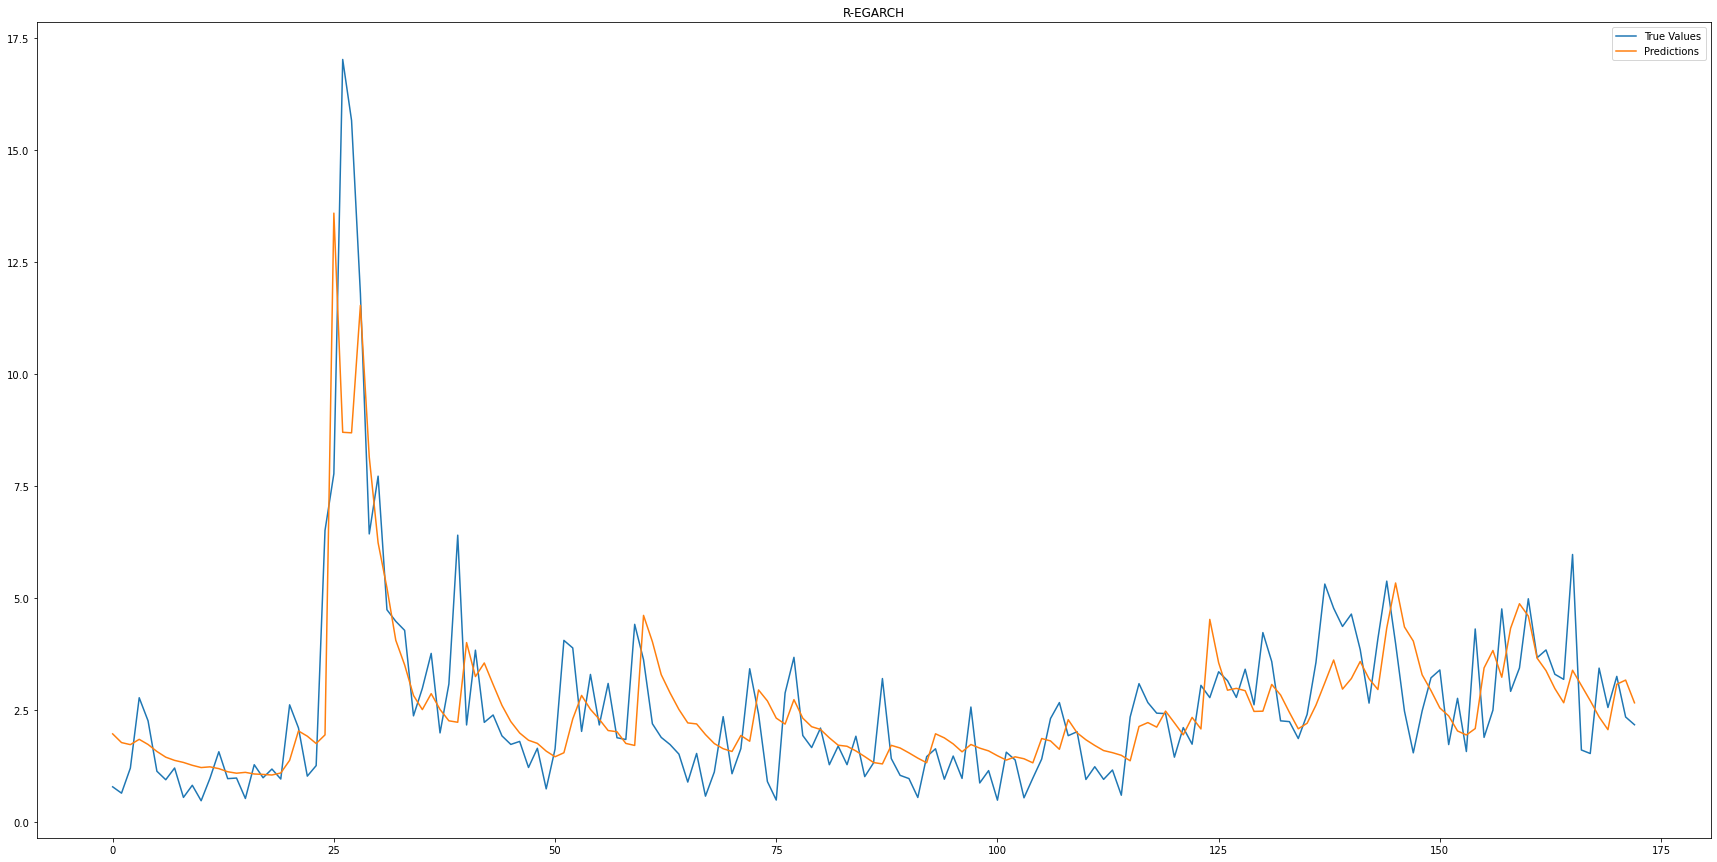

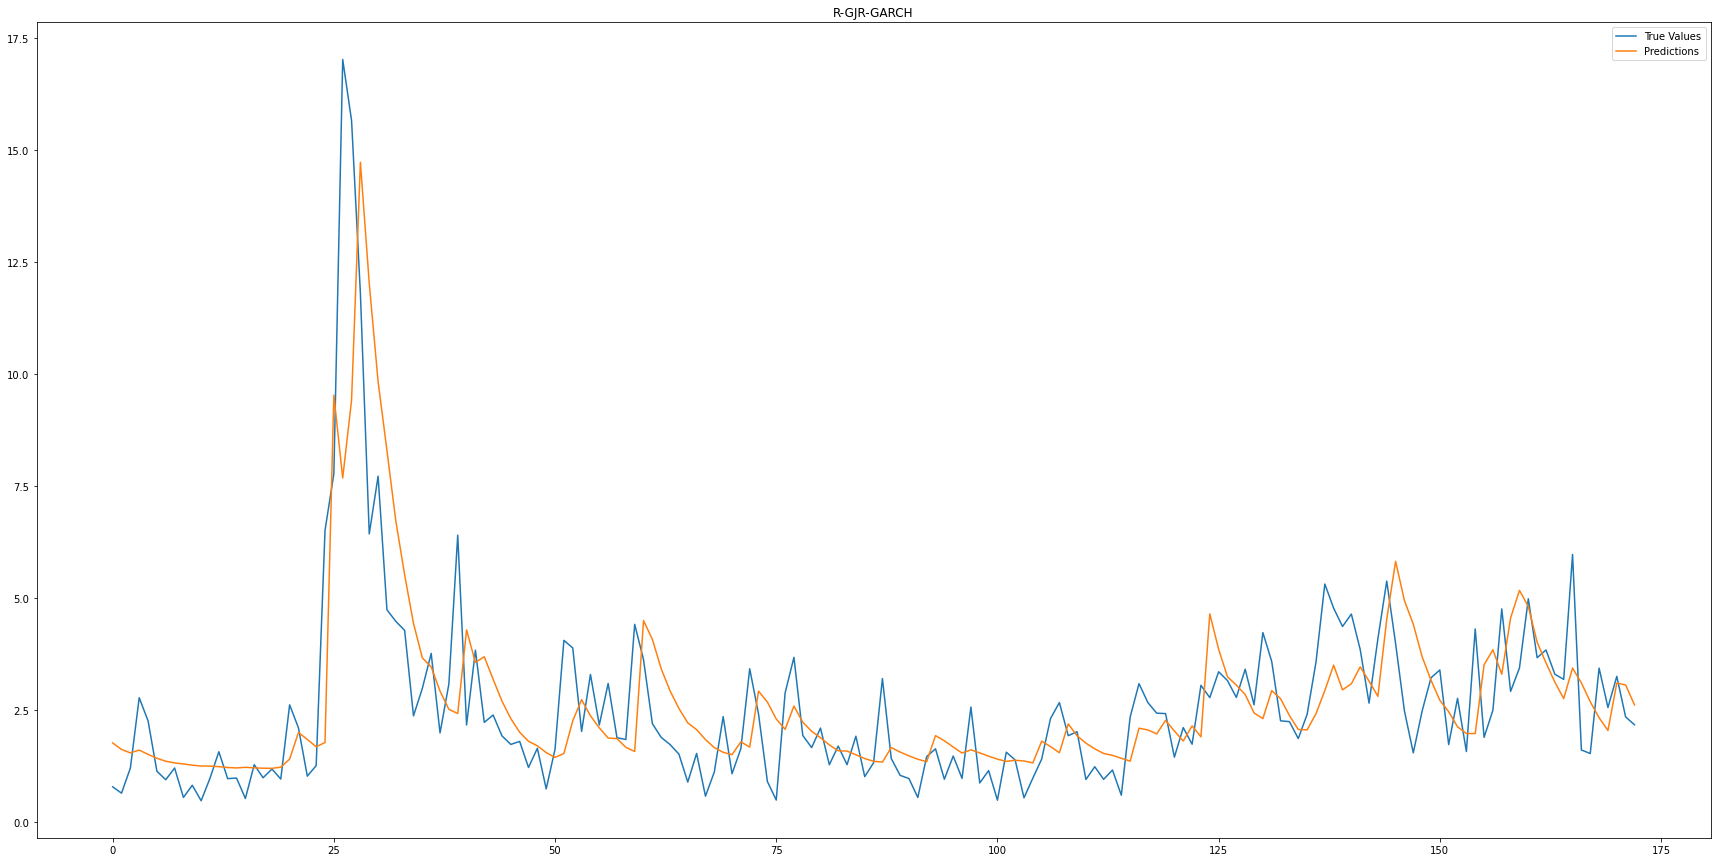

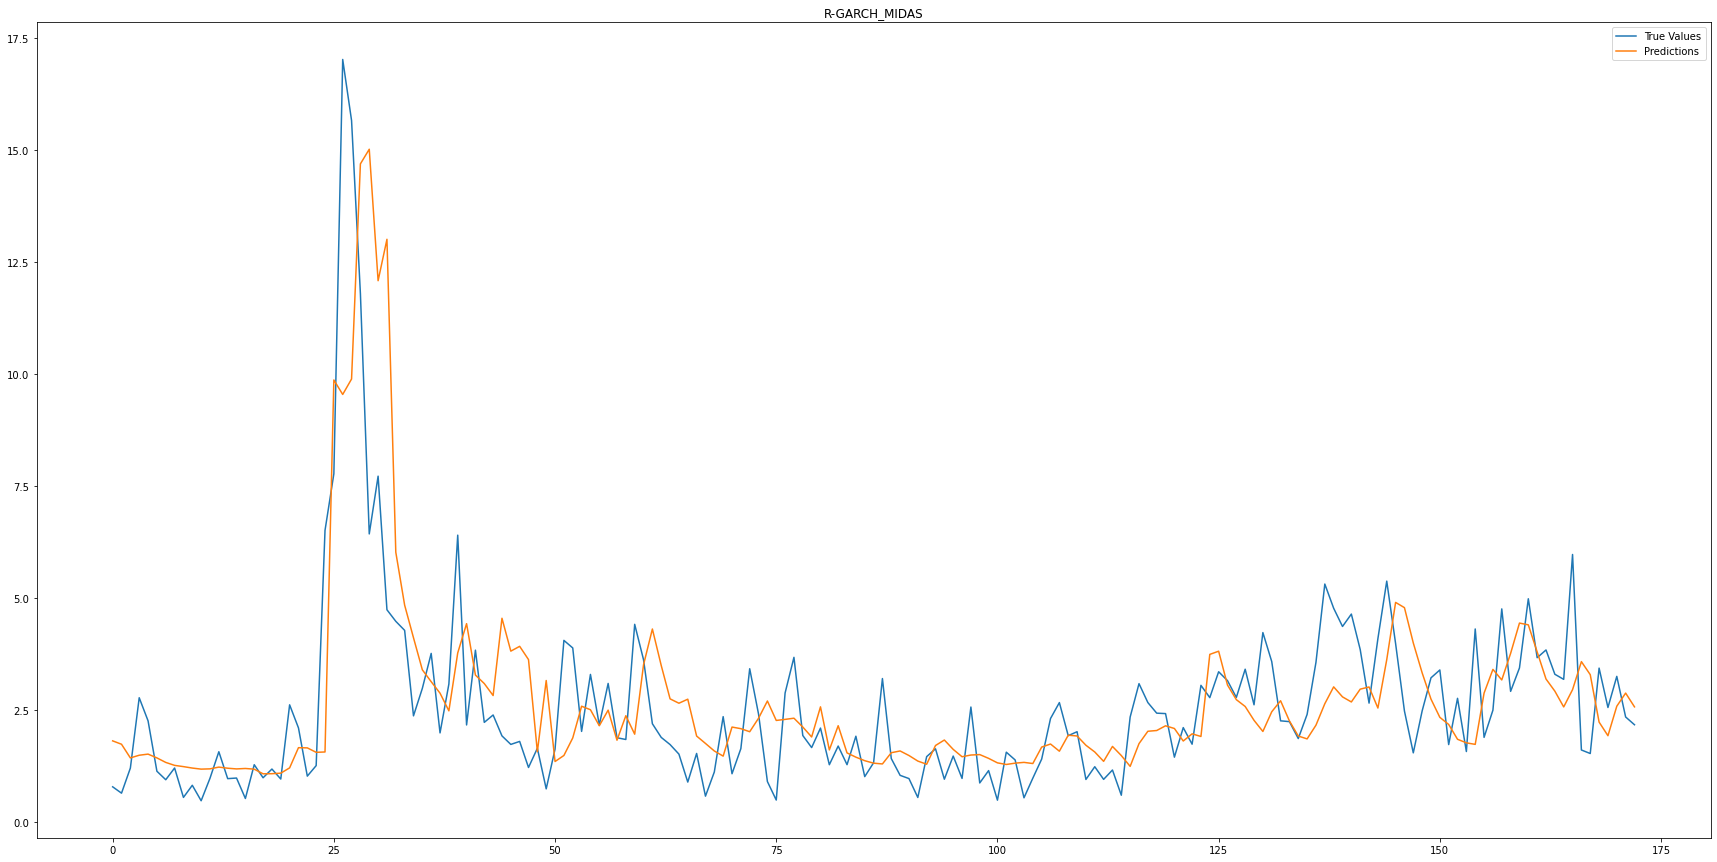

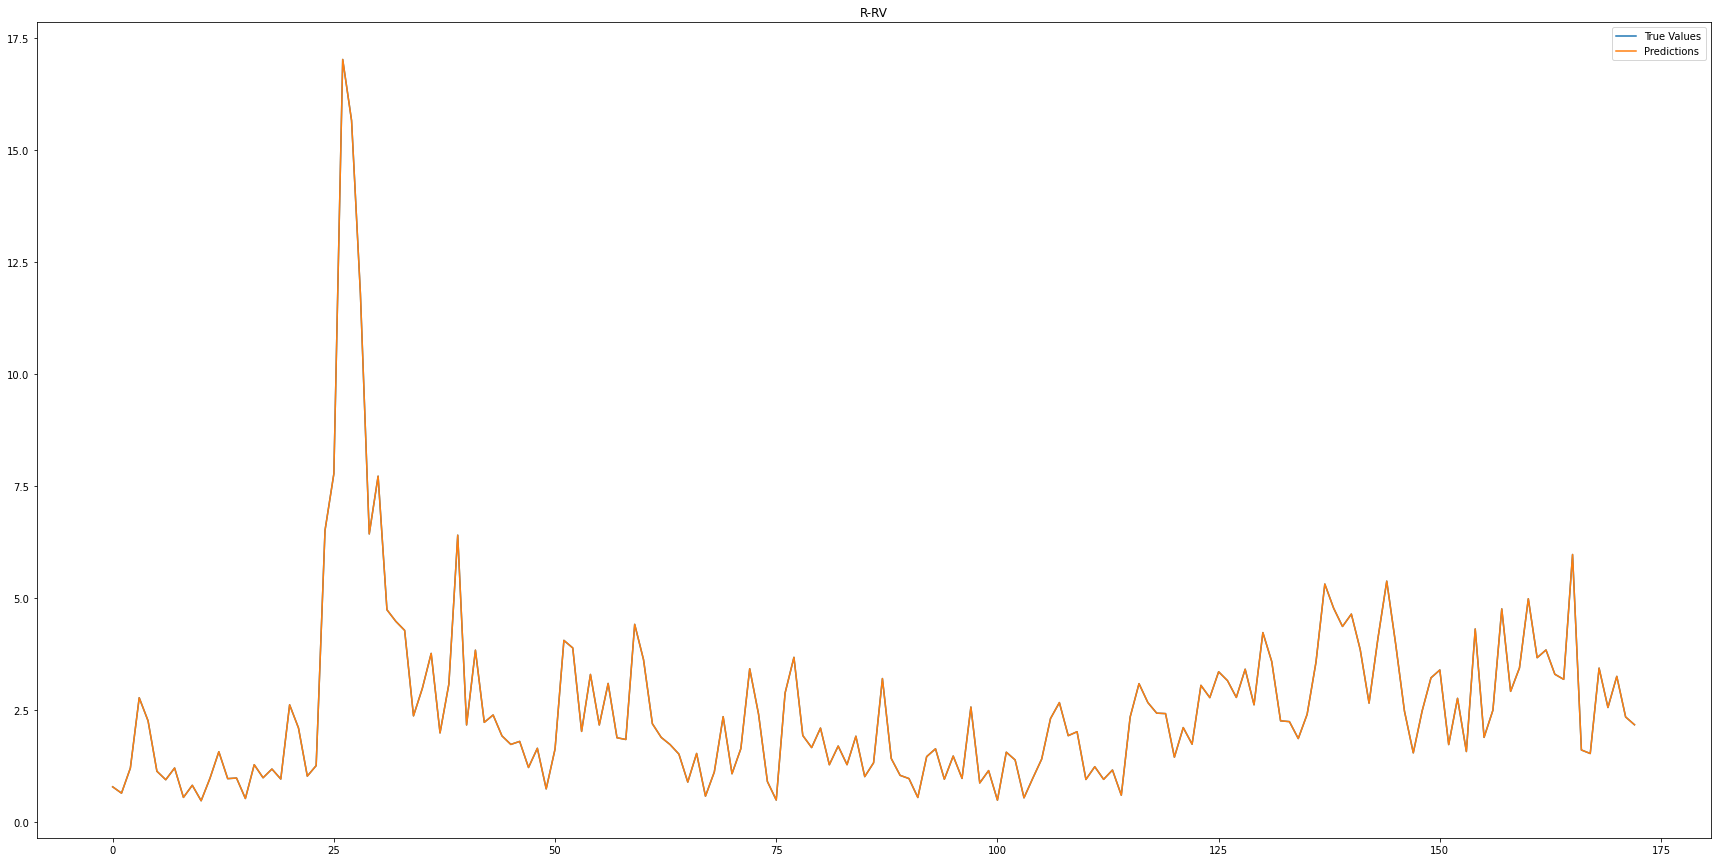

                   MAPE   RMSPE    MDA    R^2
GARCH(1,1)-FIXED  4.889  12.656  0.539  0.644
GARCH(1,1)        0.533   0.801  0.651  0.428
GJR-GARCH         0.454   0.665  0.703  0.540
EGARCH            0.528   0.801  0.663  0.472
RNGARCH           0.458   0.562  0.634  0.298
R-GARCH           0.569   0.849  0.645  0.393
R-EGARCH          0.449   0.671  0.709  0.583
R-GJR-GARCH       0.458   0.668  0.686  0.541
R-GARCH_MIDAS     0.498   0.751  0.703  0.492
R-RV              0.000   0.000  1.000  1.000


In [34]:
r_predictions = pd.read_csv('data/out_of_sample.csv', index_col=0)
r_predictions['RV'] = r_predictions['RV']**2
r_predictions['GARCH_MIDAS'] = midas_forecasts['GARCH_MIDAS'].values
new_order = ['GARCH', 'EGARCH', 'GJR-GARCH', 'GARCH_MIDAS', 'RV']
r_predictions = r_predictions[new_order]


# Loop over each model in the dataframe, and compute the efficiency metrics for each model
for model_name in r_predictions.columns:
    # Compute the efficiency metrics for the current model
    efficiency = model_efficiency(actual_volatility, r_predictions[model_name].values, f'R-{model_name}')
    plot_volatility(actual_volatility, r_predictions[model_name].values, f'R-{model_name}')
    
    # Append the efficiency DataFrame to the all_model_efficiency DataFrame
    all_model_efficiency = pd.concat([all_model_efficiency, efficiency])

print(round(all_model_efficiency, 3))


# Model fit

In [35]:
r_model_fit_data = pd.read_csv('data/model_fit.csv').drop(columns=['Unnamed: 0'])
r_model_fit_data = r_model_fit_data.rename(columns={'gamma': 'omega', 'omega': 'gamma'})

In [36]:
r_model_fit_data.index = ['R-GARCH(1, 1)', 'R-EGARCH', 'R-GJR-GARCH']
r_model_fit_data

,alpha,beta,omega,gamma,se_alpha,se_beta,se_gamma,se_omega,t_alpha,t_beta,t_gamma,t_omega,AIC,BIC
"R-GARCH(1, 1)",0.359759,0.243979,0.698845,0.000000,0.107688,0.042534,0.046633,0.000000,3.340760,5.736090,14.986065,0.000000,4.238827,4.258032
R-EGARCH,0.190255,-0.253770,0.874725,0.337690,0.037351,0.034811,0.024925,0.055871,5.093757,-7.290016,35.094450,6.044149,4.169079,4.194686
R-GJR-GARCH,0.430615,0.015458,0.698310,0.450148,0.090107,0.030679,0.045238,0.083511,4.778910,0.503853,15.436411,5.390313,4.173774,4.199381


In [37]:
model_dfs

,alpha,beta,gamma,omega,se_alpha,se_beta,se_gamma,se_omega,t_alpha,t_beta,t_gamma,t_omega,AIC,BIC
"GARCH(1, 1)",0.281077,0.665331,0.000000,0.376470,0.072139,0.065561,0.000000,0.126669,3.896338,10.148339,0.000000,2.972078,3006.600470,3024.884002
EGARCH,0.350504,0.881900,-0.231574,0.163764,0.085105,0.038853,0.050665,0.058559,4.118488,22.698262,-4.570659,2.796589,2972.437119,2995.291534
GJR-GARCH,0.028932,0.691104,0.404462,0.405898,0.038793,0.072730,0.113137,0.129670,0.745789,9.502304,3.574993,3.130236,2974.897026,2997.751441


In [43]:
model_fit_comparisons = pd.concat([model_dfs, r_model_fit_data])

,alpha,beta,gamma,omega,se_alpha,se_beta,se_gamma,se_omega,t_alpha,t_beta,t_gamma,t_omega,AIC,BIC
"GARCH(1, 1)",0.281077,0.665331,0.000000,0.376470,0.072139,0.065561,0.000000,0.126669,3.896338,10.148339,0.000000,2.972078,3006.600470,3024.884002
EGARCH,0.350504,0.881900,-0.231574,0.163764,0.085105,0.038853,0.050665,0.058559,4.118488,22.698262,-4.570659,2.796589,2972.437119,2995.291534
GJR-GARCH,0.028932,0.691104,0.404462,0.405898,0.038793,0.072730,0.113137,0.129670,0.745789,9.502304,3.574993,3.130236,2974.897026,2997.751441
"R-GARCH(1, 1)",0.359759,0.243979,0.000000,0.698845,0.107688,0.042534,0.046633,0.000000,3.340760,5.736090,14.986065,0.000000,4.238827,4.258032
R-EGARCH,0.190255,-0.253770,0.337690,0.874725,0.037351,0.034811,0.024925,0.055871,5.093757,-7.290016,35.094450,6.044149,4.169079,4.194686
R-GJR-GARCH,0.430615,0.015458,0.450148,0.698310,0.090107,0.030679,0.045238,0.083511,4.778910,0.503853,15.436411,5.390313,4.173774,4.199381
